In [1]:
import time
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_ollama import OllamaLLM, ChatOllama
from pydantic import BaseModel, Field
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langgraph.graph import StateGraph, MessagesState, START, END

In [2]:
def retrieval_agent(fetch_k:int, k:int):
    embed_model = OllamaEmbeddings(base_url="http://localhost:11434", model="bge-m3:latest")
    vectorstore = Chroma(collection_name="collection_01", persist_directory="./db/chroma_db_02", embedding_function=embed_model)
    retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={'k': k, "fetch_k":fetch_k})
    return retriever

retriever = retrieval_agent(fetch_k=10, k=3)
retriever

VectorStoreRetriever(tags=['Chroma', 'OllamaEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x00000187D7463AA0>, search_type='mmr', search_kwargs={'k': 3, 'fetch_k': 10})

In [3]:
from typing import List
from langgraph.graph import StateGraph, MessagesState, START, END
class GraphState(MessagesState):
    context : List[str]
    generation : str

In [13]:
# def generate_agent(question:str, context:list):
def generate_agent(state):

    prompt = ChatPromptTemplate.from_messages([
    ("human", 
    """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    Question: {messages} 
    Context: {context} 
    Answer:"""),
    ])
    llm = ChatGroq(temperature=0, model_name= "deepseek-r1-distill-llama-70b")  # deepseek-r1-distill-llama-70b  llama-3.3-70b-versatile

    rag_chain = prompt | llm | StrOutputParser()

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    total_docs = format_docs(state['context'])

    # Static the Response
    generation = rag_chain.invoke({"context": total_docs, "messages": state['messages']})
    return {"generation": generation}

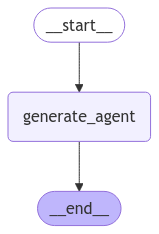

In [14]:
def rag_builder(state):
    rag_builder = StateGraph(state)

    rag_builder.add_node("generate_agent", generate_agent)
    
    rag_builder.add_edge(START, "generate_agent")
    rag_builder.add_edge("generate_agent", END)

    graph = rag_builder.compile()

    return graph

app = rag_builder(GraphState)
app

In [15]:
question = " according to lr rule, explain about ships with installed process plant for chemicals"
docs = retriever.invoke(question)
docs

[Document(metadata={'File Name': "Lloyd's Register Rules and Regulations for the Classification of Ships, July 2022", 'File Path': "/content/drive/MyDrive/Rules/LR/Lloyd's Register Rules and Regulations for the Classification of Ships, July 2022.pdf", 'First Division': 'Rules', 'Page': 1650, 'Second Division': 'LR'}, page_content="This page explains Lloyd's Register Rules and Regulations for the Classification of Ships, July 2022, that belongs to catogories of Rules and LR./nwith the process plant are to be submitted, including: • Arrangements for preventing the ingress of water into the ship or structure where process plant and equipment protrude through the weather deck. • Proposed emergency flooding procedures and their control. 3.2.6 Particulars of the proposed storage arrangements of hazardous and/or toxic substances, feedstocks and products in bulk, on the ship or structure, are to be submitted. 3.3 Process plant 3.3.1 A description of the expected method of operation of the proc

In [16]:
inputs = []
input = {"role": "user", "content": question}
inputs.append(input)
full_input = {"messages": inputs, "context": docs}
full_input

{'messages': [{'role': 'user',
   'content': ' according to lr rule, explain about ships with installed process plant for chemicals'}],
 'context': [Document(metadata={'File Name': "Lloyd's Register Rules and Regulations for the Classification of Ships, July 2022", 'File Path': "/content/drive/MyDrive/Rules/LR/Lloyd's Register Rules and Regulations for the Classification of Ships, July 2022.pdf", 'First Division': 'Rules', 'Page': 1650, 'Second Division': 'LR'}, page_content="This page explains Lloyd's Register Rules and Regulations for the Classification of Ships, July 2022, that belongs to catogories of Rules and LR./nwith the process plant are to be submitted, including: • Arrangements for preventing the ingress of water into the ship or structure where process plant and equipment protrude through the weather deck. • Proposed emergency flooding procedures and their control. 3.2.6 Particulars of the proposed storage arrangements of hazardous and/or toxic substances, feedstocks and pr

In [17]:
temp = []
async for event in app.astream_events(full_input, version="v1"):
    if event['event'] == 'on_chat_model_stream' or event['event'] == 'on_llm_stream':
        # print(event)
        try:
            response = event['data']['chunk'].content
            temp.append(response)
            print(response, end="")   # groq
            time.sleep(0.1)
        except:
            response = event['data']['chunk']
            temp.append(response)
            print(response, end="")    # ollama
            time.sleep(0.1)
        finally: pass
    else: pass

<think>
Okay, I need to explain the Lloyd's Register Rules for ships with installed process plants for chemicals. Let me go through the context provided.

First, the context mentions that ships with process plants must submit various details. These include arrangements to prevent water ingress, emergency flooding procedures, and storage plans for hazardous substances. So, I should mention these requirements.

Next, the process plant itself needs a description of its operation and a process flow diagram. Also, general arrangement plans showing hazardous and safe zones are required. I should include this in the explanation.

The context also talks about special notations for ships handling chemical cargoes. These notations depend on the ship's category and operational conditions, like being moored or in harbor. I should explain how these notations are assigned based on the ship's design and operation.

Putting it all together, I'll structure the answer to cover the submission requirement

In [10]:
total_res = "".join(temp[:])
inputs.append({"role": "ai", "content": total_res})
print(inputs)
print(len(inputs))

[{'role': 'user', 'content': ' according to lr rule, explain about ships with installed process plant for chemicals'}, {'role': 'ai', 'content': "<think>\nOkay, I need to answer the question about Lloyd's Register rules for ships with installed process plants for chemicals. Let me go through the context provided.\n\nFirst, the context mentions that ships with process plants must submit various details. These include arrangements to prevent water ingress, emergency flooding procedures, and storage plans for hazardous substances. So, I should mention these requirements.\n\nNext, the process plant itself needs a description of its operation and a process flow diagram. Also, general arrangement plans showing hazardous and safe zones are required. I should include this in the answer.\n\nAdditionally, the context talks about special notations for ships based on their category and operation. For example, Category 1B or 2 ships with liquefaction plants get specific notations. Ships that can on

In [11]:
question = "what is the noon report in iss system?"
docs = retriever.invoke(question)
print(len(docs))
input = {"role": "user", "content": question}
inputs.append(input)
full_input = {"messages": inputs, "context": docs}
full_input

3


{'messages': [{'role': 'user',
   'content': ' according to lr rule, explain about ships with installed process plant for chemicals'},
  {'role': 'ai',
   'content': "<think>\nOkay, I need to answer the question about Lloyd's Register rules for ships with installed process plants for chemicals. Let me go through the context provided.\n\nFirst, the context mentions that ships with process plants must submit various details. These include arrangements to prevent water ingress, emergency flooding procedures, and storage plans for hazardous substances. So, I should mention these requirements.\n\nNext, the process plant itself needs a description of its operation and a process flow diagram. Also, general arrangement plans showing hazardous and safe zones are required. I should include this in the answer.\n\nAdditionally, the context talks about special notations for ships based on their category and operation. For example, Category 1B or 2 ships with liquefaction plants get specific notatio

In [12]:
temp = []
async for event in app.astream_events(full_input, version="v1"):
    if event['event'] == 'on_chat_model_stream' or event['event'] == 'on_llm_stream':
        # print(event)
        try:
            response = event['data']['chunk'].content   # groq
            temp.append(response)
            print(response, end="")  
            time.sleep(0.1)
        except:
            response = event['data']['chunk']  # ollama
            temp.append(response)
            print(response, end="")    
            time.sleep(0.1)
        finally: pass
    else: pass

<think>
Okay, so I need to figure out what the noon report in the ISS system is. I remember that the user provided some context, but I'm not sure if it's relevant. Let me look through the context again.

The context talks about SOLAS, ship reporting systems, ECDIS, and ISM audits. It mentions things like mandatory reporting for search and rescue, VTS, weather forecasting, and pollution prevention. There's also stuff about tankers having emergency towing arrangements and some rules about navigation bridge systems and safety management audits.

Hmm, I don't see anything about a "noon report" specifically. Maybe it's related to daily reporting practices? Ships often have noon reports that include position, weather, fuel, etc., but the context doesn't mention this. The ISS system might be a specific system, but the provided context doesn't explain it. I don't have enough information here to answer accurately.
</think>

The noon report in the ISS system isn't explained in the provided conte

In [13]:
total_res = "".join(temp[:])
total_res

"I don't know about ships with installed process plants for chemicals. The retrieved context only mentions IMO-SOLAS regulations and rules for navigation bridge systems, audit and registration of safety management systems, but not process plants for chemicals."